In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


memory usage: 7.5+ GB
Видим, что столбцы имеют типы int64/float64/object, которые здесь избыточны. Приведём к типам, соотвествующим описанию:

In [3]:
types_mapping = {
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'bool'
    }
train_df = train_df.astype(types_mapping)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  bool   
dtypes: bool(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 3.0 GB


memory usage: 3.0 GB.
Также посмотрим столбец row_id - он копирует наш индекс и от него можно избавиться:

In [4]:
train_df.drop('row_id', axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  bool   
dtypes: bool(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 2.3 GB


Посмотрим колонку timestamp, где лежит интервал в миллисекундах:

In [5]:
train_df['timestamp'].describe()

count    1.012303e+08
mean     7.703644e+09
std      1.159266e+10
min      0.000000e+00
25%      5.243436e+08
50%      2.674234e+09
75%      9.924551e+09
max      8.742577e+10
Name: timestamp, dtype: float64

Большие значения (max - 8.742577e+10) тяжело интерпретировать, преобразуем в интервалы:

In [6]:
train_df['timestamp'] = pd.to_timedelta(train_df['timestamp'], unit='ms')
train_df['timestamp'].describe()

count                      101230332
mean      89 days 03:54:03.654326504
std      134 days 04:10:55.308525576
min                  0 days 00:00:00
25%           6 days 01:39:03.559000
50%          30 days 22:50:33.764500
75%         114 days 20:49:10.562750
max        1011 days 20:56:12.049000
Name: timestamp, dtype: object

Среднее число - 89 дней, 3/4 укладываются в 114 дней, но есть и долгие периоды до 1011 дней.

Посмотрим колонку prior_question_elapsed_time, где также интервалы в миллисекундах:

In [7]:
train_df['prior_question_elapsed_time'].describe()

count    9.887879e+07
mean     2.542384e+04
std      2.122839e+04
min      0.000000e+00
25%      1.600000e+04
50%      2.100000e+04
75%      2.966600e+04
max      3.000000e+05
Name: prior_question_elapsed_time, dtype: float64

Здесь нет смысла переводить в интервалы, так как все значения - от 0 до 300 секунд. Поэтому просто поделим на 1000 и переведём в секунды:

In [8]:
train_df['prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'] / 1000
train_df['prior_question_elapsed_time'].describe()

count    9.887879e+07
mean     2.542385e+01
std      2.127586e+01
min      0.000000e+00
25%      1.600000e+01
50%      2.100000e+01
75%      2.966600e+01
max      3.000000e+02
Name: prior_question_elapsed_time, dtype: float64

Проанализируем пропуски:

In [9]:
train_df.isna().sum()

timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation          0
dtype: int64

Пропуски есть только в prior_question_elapsed_time, но судя по описанию столбца это возможно. 

Проверим на дубликаты, и если есть - очистим от них:

In [10]:
train_df.duplicated().sum()

135

In [11]:
train_df.drop_duplicates(keep='last', inplace=True)

In [12]:
train_df.shape

(101230197, 9)

# Загрузим файл вопросов questions:

In [13]:
questions_df = pd.read_csv('questions.csv')
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [14]:
questions_df.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


Приведём к соотвествующим типам:

In [15]:
types_mapping = {
    'question_id': 'int16',
    'bundle_id': 'int16',
    'correct_answer': 'int8',
    'part': 'int8',
    }
questions_df = questions_df.astype(types_mapping)
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
dtypes: int16(2), int8(2), object(1)
memory usage: 185.0+ KB


In [16]:
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


Проверим, вдруг question_id и bundle_id дублируют друг друга:

In [17]:
(questions_df['question_id'] == questions_df['bundle_id']).value_counts()

True     9765
False    3758
Name: count, dtype: int64

Подозрение не подтвердилось, значения бывают разные, так что оставим их как есть

Проверим на дубликаты:

In [18]:
questions_df.duplicated().sum()

0

# Выделим из train данные по вопросам и смёржим с таблицей questions:

In [19]:
questions_in_train = train_df[train_df['content_type_id'] == 0]
train_with_questions_df = pd.merge(questions_in_train, questions_df, left_on='content_id', right_on='question_id', how='left')
train_with_questions_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0 days 00:00:00,115,5692,0,1,3,1,NaN,True,5692,5692,3,5,151
1,0 days 00:00:56.943000,115,5716,0,2,2,1,37.0,False,5716,5716,2,5,168
2,0 days 00:01:58.363000,115,128,0,0,0,1,55.0,False,128,128,0,1,131 149 92
3,0 days 00:02:11.167000,115,7860,0,3,0,1,19.0,False,7860,7860,0,1,131 104 81
4,0 days 00:02:17.965000,115,7922,0,4,1,1,11.0,False,7922,7922,1,1,131 149 92


Проверим, правильность данных в answered_correctly, сравнив ответы пользователя с правильным ответом:

In [20]:
answers_comparison = train_with_questions_df['user_answer'] == train_with_questions_df['correct_answer']
(train_with_questions_df['answered_correctly'] == answers_comparison).value_counts()

True    99271165
Name: count, dtype: int64

Данные корректны. Теперь удалим один из дублирующих столбцов ответов (correct_answer), а также столбцы content_type_id (везде 0, не несёт информации), content_id (дублируется с question_id):

In [21]:
train_with_questions_df.drop(columns=['content_id', 'correct_answer', 'content_type_id'], axis=1, inplace=True)

Посмотрим процент правильных ответов:

In [22]:
correct_answers = train_with_questions_df['answered_correctly'].value_counts(normalize=True)
correct_answers

answered_correctly
1    0.657235
0    0.342765
Name: proportion, dtype: float64

<Axes: ylabel='proportion'>

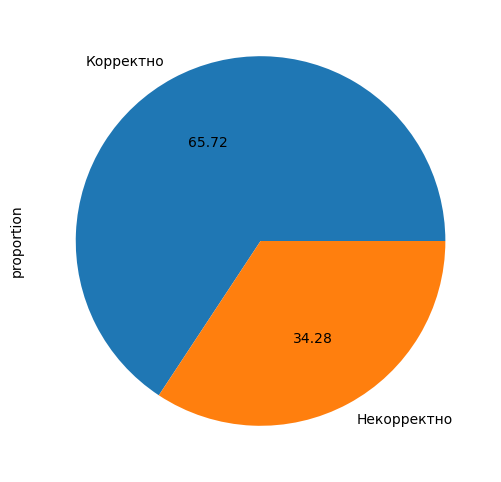

In [23]:
correct_answers.plot.pie(labels=['Корректно', 'Некорректно'], autopct='%.2f', figsize=(6, 6))

Найдём доли правильных ответов в зависимости от части задания и визуализируем их:

In [24]:
answers_by_part = train_with_questions_df.groupby('part')['answered_correctly'].value_counts(normalize=True).unstack()[1]
answers_by_part

part
1    0.745032
2    0.708694
3    0.701456
4    0.630997
5    0.610088
6    0.669388
7    0.659601
Name: 1, dtype: float64

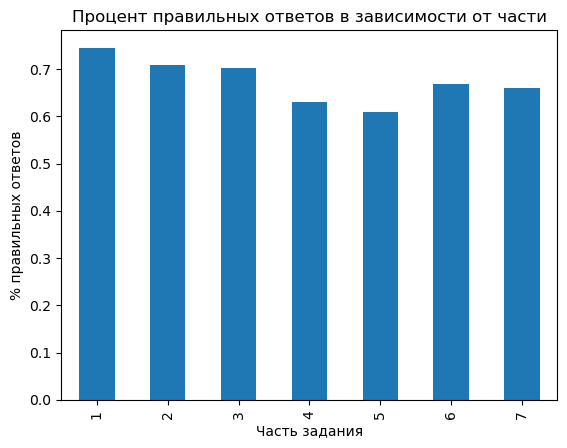

In [25]:
answers_by_part.plot(kind='bar')
plt.title('Процент правильных ответов в зависимости от части')
plt.xlabel('Часть задания')
plt.ylabel('% правильных ответов')
plt.show()

Видимо вопросы 4 и 5 части сложнее в среднем, чем вопросы в остальных частях, тк процент правильных ответов в них ниже.

Посмотрим как меняется доля правильных ответов в зависимости от прихзнака prior_question_had_explanation - смотрел ли человек правильный ответ на предыдущий вопрос:

In [26]:
answers_by_explanation = train_with_questions_df.groupby('prior_question_had_explanation')['answered_correctly'].value_counts(normalize=True).unstack()
answers_by_explanation

answered_correctly,0,1
prior_question_had_explanation,,
False,0.499372,0.500628
True,0.326782,0.673218


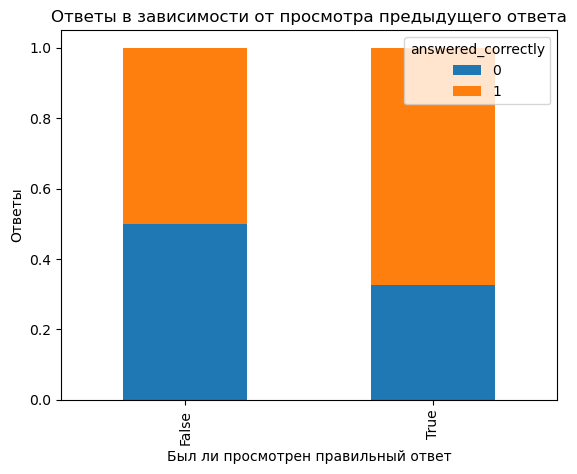

In [27]:
answers_by_explanation.plot(kind='bar', stacked=True)
plt.title('Ответы в зависимости от просмотра предыдущего ответа')
plt.xlabel('Был ли просмотрен правильный ответ')
plt.ylabel('Ответы')
plt.show()

Видно, что если пользователь просматривал правильные ответы на предыдущие вопросы, то процент правильных ответов был 67, если не просматривал - 50

Посмотрим, есть ли разница по времени при правильных и неправильных ответах:

In [28]:
answers_by_time = train_with_questions_df.groupby('answered_correctly')['prior_question_elapsed_time'].mean()
answers_by_time

answered_correctly
0    25.641981
1    25.309975
Name: prior_question_elapsed_time, dtype: float32

Разницы практически нет

# Загрузим данные по лекциям

In [29]:
lectures_df = pd.read_csv('lectures.csv')
lectures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [30]:
lectures_df.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


In [31]:
types_mapping = {
    'lecture_id': 'int16',
    'part': 'int8',
    }
lectures_df = lectures_df.astype(types_mapping)
lectures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int16 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int8  
 3   type_of     418 non-null    object
dtypes: int16(1), int64(1), int8(1), object(1)
memory usage: 7.9+ KB


In [32]:
lectures_df['type_of'].value_counts()

type_of
concept             222
solving question    186
intention             7
starter               3
Name: count, dtype: int64

type_of - всего 4 различных значения. Приведём к категориальному типу:

In [33]:
lectures_df['type_of'] = lectures_df['type_of'].astype('category')

Проверим на дубликаты:

In [34]:
lectures_df.duplicated().sum()

0

Посмотрим, изменяются ли типы в зависимости от части:

In [35]:
by_part = lectures_df.groupby('part')['type_of'].value_counts(normalize=True).unstack()
by_part

type_of,concept,intention,solving question,starter
part,,,,
1,0.370370,0.000,0.629630,0.000000
2,0.321429,0.125,0.553571,0.000000
3,0.368421,0.000,0.631579,0.000000
4,0.612903,0.000,0.387097,0.000000
5,0.503497,0.000,0.482517,0.013986
6,0.759036,0.000,0.228916,0.012048
7,0.718750,0.000,0.281250,0.000000


<Axes: xlabel='part'>

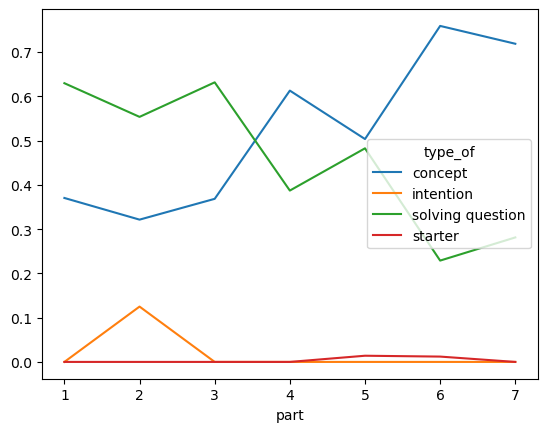

In [36]:
by_part.plot()

Видно, что доля solving_questions падает, а concept растёт в зависимости от part